In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [7]:
# read in excel with techniques and probabilities, sheet X removed latest 20%
excel_file_X = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\reduced_table_with_timestamps_and_props.xlsx", sheet_name="X")
excel_file_X = excel_file_X.set_index(["ID"])

# read in excel with correlations of techniques needed for fitness function
excel_corr = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\regression\corr_techniques.xlsx", sheet_name = "Sheet1")
excel_corr = excel_corr.drop('Unnamed: 0', 1)

# extract probabilities from excel and save as pd data frame
probs = pd.DataFrame(excel_file_X.iloc[0])
probs.iloc[0]
probs = probs.iloc[1:]

# read in excel with newest 20 percent of techniques for evaluation
excel_file_Y = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\reduced_table_with_timestamps_and_props.xlsx", sheet_name="y")
excel_file_Y = excel_file_Y.drop(excel_file_Y.tail(2).index, axis=0)
excel_file_Y.set_index('ID', inplace = True)
excel_file_Y_t = excel_file_Y.T
excel_file_Y_t = excel_file_Y_t.drop(['created'], axis = 0)

excel_corr

,1,2,3,4,5,6,7,8,9,10,...,260,261,262,263,264,265,266,267,268,269
0,1.000000,-0.015059,0.103402,0.238980,0.270487,0.127714,0.328829,-0.015059,0.110425,0.056578,...,0.115306,0.025799,0.167711,0.014296,-0.015059,-0.032176,0.028190,0.094802,-0.021340,0.075569
1,-0.015059,1.000000,-0.008703,-0.008703,-0.004073,-0.004073,-0.008197,-0.004073,-0.011689,-0.007084,...,-0.014438,-0.009642,-0.016246,-0.010911,-0.004073,-0.008703,-0.014751,-0.009183,-0.005772,-0.020961
2,0.103402,-0.008703,1.000000,0.207759,-0.008703,0.229665,-0.017513,0.229665,0.146032,-0.015136,...,0.039559,-0.020600,0.028669,-0.023313,-0.008703,-0.018595,0.037540,-0.019621,-0.012333,0.108543
3,0.238980,-0.008703,0.207759,1.000000,0.229665,0.229665,0.222324,-0.008703,0.231536,-0.015136,...,0.109965,-0.020600,-0.034711,-0.023313,-0.008703,-0.018595,0.037540,-0.019621,-0.012333,0.108543
4,0.270487,-0.004073,-0.008703,0.229665,1.000000,-0.004073,0.244369,-0.004073,0.168394,-0.007084,...,-0.014438,-0.009642,-0.016246,-0.010911,-0.004073,-0.008703,-0.014751,-0.009183,-0.005772,0.086683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,-0.032176,-0.008703,-0.018595,-0.018595,-0.008703,-0.008703,-0.017513,-0.008703,0.060529,-0.015136,...,-0.030847,0.081985,-0.034711,0.067903,-0.008703,1.000000,-0.031517,-0.019621,-0.012333,0.108543
265,0.028190,-0.014751,0.037540,0.037540,-0.014751,0.130694,-0.029684,-0.014751,0.009842,0.058663,...,0.076596,0.027679,0.134530,-0.039513,-0.014751,-0.031517,1.000000,0.163488,-0.020904,0.017649
266,0.094802,-0.009183,-0.019621,-0.019621,-0.009183,-0.009183,-0.018480,-0.009183,-0.026353,0.115259,...,-0.032550,0.075684,0.143943,-0.024599,-0.009183,-0.019621,0.163488,1.000000,-0.013014,0.001280
267,-0.021340,-0.005772,-0.012333,-0.012333,-0.005772,-0.005772,-0.011616,-0.005772,-0.016564,-0.010039,...,-0.020459,0.139425,-0.023022,-0.015462,-0.005772,-0.012333,-0.020904,-0.013014,1.000000,0.046567


In [3]:
# read csv, convert creation dates to datetime format, sort column creation date
# csv_file = pd.read_csv(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\matrix-with-timestemps-READY.csv",sep=";")
# csv_file_t = csv_file.T
# new_header = csv_file_t.iloc[0] #grab the first row for the header
# csv_file_t = csv_file_t[1:] #take the data less the header row
# csv_file_t.columns = new_header #set the header row as the df header
# csv_file_t['created'] = pd.to_datetime(csv_file_t['created'])
# csv_file_t
# csv_file_t.sort_values(by=['created'])

In [4]:
# function to create a starting population
def create_starting_population(individuals):
    # maybe later: add restriction for amount of ones in chromosome --> added
    # population = np.random.randint (2, size=(individuals, len(probs)))
    population = np.random.choice([0,1], size=(individuals, len(probs)), p= np.array([0.96,0.04])) # adjust % for number of ones
    return population

In [5]:
# example starting population
# print (create_starting_population(6))


In [18]:
# function to calculate fitness of every individual in the current population
def calculate_fitness(individuals, probs, print_out = False, lamda_balance = 0.2, bonus_factor = 135, penalty_factor = 12):
    
    len_pop = len(probs)
    individuals = np.array(individuals) # individuals = 6x269
    probs = np.array (probs) # array with probabilities 269x1
    ones = np.ones(len_pop) # number of ones 269x1
    occurrences = (individuals @ ones) # number of ones in individual 6x1
    P = individuals # 6x269
    corr = np.array(excel_corr).reshape(len_pop,len_pop)
    np.fill_diagonal(corr, 0) # 269x269, correlation matrix with 0 self covariance
    A = (P @ corr) # 6x269
    K = (P @ A.T) # 6x6
    corr_term = K.diagonal()/len_pop # diagonal elements of matrix K 
#   print(k.shape)
    
#    corr = (individuals @ excel_corr) # array with population x correlations 6x269
#    print(corr)
#    print(excel_corr.shape)
#    print(corr.shape)
    
#     print (occurrences)
#     print (individuals.shape)
#     print (probs.shape)
    
    
    
    prob_term = (individuals @ probs) # a includes values between 0 and 1
    b = (np.subtract(occurrences,8)) # Intervall?
#   penalty_term = ((b+8/len_pop)-0.5)*2
    pen_1 = (b**2)*np.sign(b)/penalty_factor
    pen_1[pen_1 < 0] = 0
    pen_2 = np.copy(b)/bonus_factor
    pen_2[pen_2 > 0] = 0
    penalty_term = (pen_1+pen_2)
#   penalty_term = (b**3)/2 # Wert 2 und 1 muss noch angepasst werden
# wenn wir 0 eingeben, kommt -8; es soll aber -1 werden, wenn 269 kommt 261 raus; es soll aber 1 sein, Mittelwert
# ((b+8/269)-0.5)*2
# b-min/max-min
#     target = 100*(individuals @ probs)
#     penalty = (np.subtract(occurrences,11))
#     for x in penalty:
#         if x > 0: # if occurence of 1s is higher than the average of 11
#             x = (x**2)/2
#         else: # if occurence of 1s is below the average of 11
#             x = x*20
        
    if print_out:
        print("probs")
        print(probs.shape)
        print("prob_term")
        print (prob_term)
        print("occurences")
        print(occurrences.shape)
        print("b")
        print (b)
        print("penalty_term")
        print (penalty_term)
        print("corr_term")
        print(corr_term)
        print("len_pop")
        print(len_pop)
    fitness_scores = ((lamda_balance*prob_term.T+corr_term*(1-lamda_balance))-penalty_term) # best results with a.t/2+k*0.7-c
#    fitness_scores = fitness_scores_nd.tolist()
#    fitness_scores = np.subtract((k), c)
#    fitness_scores = np.subtract(a.T, c)
#    print (fitness_scores.shape)
    
    return fitness_scores[0]

In [19]:
# inp = np.array([2, -1, 7, -2])
# x = (inp**2)*np.sign(inp)
# # x = x/max(x)
# x[x < 0] = 0
# y = inp
# # y = y/max(y)
# y[y > 0] = 0
# (y+x)/12 

In [20]:
test1 = create_starting_population(6)
print('Startpopulation')
print(test1)

calculate_fitness(test1, probs, print_out = True)

Startpopulation
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
probs
(269, 1)
prob_term
[[0.09253170502583369]
 [0.027477689055894785]
 [0.06693283231564115]
 [0.06153123532174729]
 [0.06082667919210897]
 [0.04133395960544856]]
occurences
(6,)
b
[8. 0. 0. 9. 6. 2.]
penalty_term
[5.33333333 0.         0.         6.75       3.         0.33333333]
corr_term
[0.02282033 0.01134616 0.00533048 0.02704398 0.01860414 0.02273865]
len_pop
269


array([-5.296570727333319, 0.014572465517651513, 0.017650946536019396,
       -6.716058569100505, -2.9729513555323597, -0.30687562239412575],
      dtype=object)

In [34]:
# pd.set_option('display.max_columns', None)
# pd.DataFrame(test1)

In [35]:
#function to select individuals by using tournament selection
def select_individual_by_tournament(population, scores):
#     print (population)
#     print ("pop - scores")
#     print (scores)
    
    # get population size
    population_size = len(scores)
#    print(scores)

    # pick individuals for tournament
    fighter_1 = random.randint(0, population_size-1)
    fighter_2 = random.randint(0, population_size-1)
    
    # get fitness score for each individual
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
#    print(fighter_1_fitness)
#     print (scores[0])
    
    # identify undividual with highest fitness
    # fighter 1 will win if scores are equal
    if fighter_1_fitness >= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    #return the chromsome of the winner
    return population[winner, :]

In [36]:
# select_individual_by_tournament(population, calculate_fitness(test1, probs))

In [37]:
# function to select individuals by using roulette wheel selection
# cannot be used yet, since it does not accept negative fitness values
# fitness value will represent the selection probability, which can't be negative
# idea1: normalise fitness values
# idea2: subtract the lowest (negative) value from all fitness values. The lowest fitness value is now zero.
def select_individual_by_roulette(population, k, scores): # list of individuals to select from, number of individuals to select, attribute to use as selection criteria
    s_inds = sorted(individuals, key = attrgetter(scores), reverse = True)
    sum_sc = sum(getattr(ind, scores).values[0] for ind in population)
    chosen = []
    for i in range(k):
        u = random.random()*sum_sc
        sum1 = 0
        for ind in s_inds:
            sum1 += getattr(ind, scores).values[0]
            if sum1 > u:
                chosen.append(ind)
                break
            
    return chosen

In [38]:
# function for executing one point crossover
# def breed_by_crossover_1point(parent_1, parent_2):
#     # get length of chromosome
#     chromosome_length = min(len(parent_1), len(parent_2))
    
#     # pick crossover point, avoding ends of chromsome
#     crossover_point = random.randint(1,chromosome_length-1)
    
#     # create children. np.hstack joins two arrays
#     child_1 = np.hstack((parent_1[0:crossover_point],
#                         parent_2[crossover_point:]))
    
#     child_2 = np.hstack((parent_2[0:crossover_point],
#                         parent_1[crossover_point:]))
    
#     # return children
#     return child_1, child_2

In [39]:
# function for executing one point crossover
def breed_by_crossover_1point(ind1, ind2):
    chromosome_length = min(len(ind1), len(ind2))
    crossover_point = random.randint(1, chromosome_length-1)
    
    ind1[crossover_point:], ind2[crossover_point:] = ind2[crossover_point:], ind1[crossover_point:]
    
    return ind1, ind2

In [40]:
# function for executin two point crossover
def breed_by_crossover_2point(ind1, ind2):
    chromosome_length = min(len(ind1), len(ind2))
    crossover_point1 = random.randint(1, chromosome_length)
    crossover_point2 = random.randint(1, chromosome_length-1)
    
    if crossover_point2 >= crossover_point1:
        crossover_point2 += 1
    else: # swapping the two crossover points
        crossover_point1, crossover_point2 = crossover_point2, crossover_point1
        
    ind1[crossover_point1: crossover_point2], ind2[crossover_point1: crossover_point2] \
        = ind2[crossover_point1: crossover_point2], ind1[crossover_point1: crossover_point2]
    
    return ind1, ind2

In [41]:
# function for executing uniform crossover
def breed_by_crossover_uniform(ind1, ind2, indpb):
    # parameter indpb is the indipendent probability for each bit to be exchanged
    # get length of chromosome
    chromosome_length = min(len(ind1), len(ind2))
    
    for i in range(chromosome_length):
        if random.random() < indpb: #add: lower probability that 0 --> 1 than the probability that 1 --> 0
             ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

In [42]:
# function to mutate population
def randomly_mutate_population(population, mutation_probability):
    
    # apply random mutation
        random_mutation_array = np.random.random(
            size=(population.shape))
        
        random_mutation_boolean = \
            random_mutation_array <= mutation_probability

        population[random_mutation_boolean] = \
        np.logical_not(population[random_mutation_boolean])
        
        # return mutation population
        return population

Starting best score: 0.0
End best score 0.1
[ 8.  7. 10.  8.  8.  9.  8.  8.  8.  8. 10.  8.  8.  8.  8.  8.  9.  8.
  8.  8.]


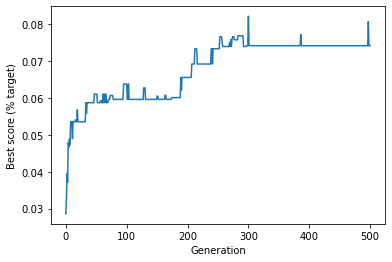

In [57]:
# main algorithm code
# set general parameters
chromosome_length = len(probs)
population_size = 20
maximum_generation = 500 # tested with 1000 generations, 250 to 300 generations seems reasonable for iterations
best_score_progress = [] # tracks progress

# create starting population
population = create_starting_population(population_size)

# print (population)
# display best score in starting population
scores = calculate_fitness(population, probs)
best_score = np.max(scores)
print ('Starting best score: %.1f' %best_score)

# add starting best score to progress tracker
best_score_progress.append(best_score)

# going through the generations of genetic algorithm
for generation in range(maximum_generation):
    # create an empty list for new population
    new_population = []
    
    # create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = select_individual_by_tournament(population, scores)
        parent_2 = select_individual_by_tournament(population, scores)
        #child_1, child_2 = breed_by_crossover_1point(parent_1, parent_2)
        #child_1, child_2 = breed_by_crossover_2point(parent_1, parent_2) # Results are not as promising as with the others
        child_1, child_2 = breed_by_crossover_uniform(parent_1, parent_2, 0.5)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # replace the old population with the new one
    population = np.array(new_population)
    
    # apply mutation
    mutation_rate = 0.001
    population = randomly_mutate_population(population, mutation_rate)

    # score best solution, and add to tracker
    scores = calculate_fitness(population, probs)
    best_score = np.max(scores)
    best_score_progress.append(best_score)
    
    # print(best_score)

# GA has completed required generation number
print ('End best score %.1f' %best_score)

ones = np.ones(len(probs)) # number of ones 269x1
occurrences = (population @ ones)
print (occurrences)

# plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()

In [58]:
# for i in range(0,10):
#     print (population[i])

In [59]:
# Print out information about best individuum
print('Best score target generation: %.1f' %best_score)
max_index_row = np.argmax(scores, axis=0)
print ('Position in Array:', max_index_row)
print("Number of Ones:", occurrences[max_index_row])
print("")
print("Respective Chromosome:", population[max_index_row] )
print("")

print("Techniques used:")
i = 0
for row in probs.index: 
    if population [max_index_row][i] == 1:
        print(row)
    i+=1
#excel_file_Y_t = excel_file_Y_t.set_index(['ID'])
#excel_file_Y_t = excel_file_Y_t.drop([100,101], axis = 1)

best_sw = np.tile(population[max_index_row],1) 
# excel_file_Y_t
# print(scores)

Best score target generation: 0.1
Position in Array: 0
Number of Ones: 8.0

Respective Chromosome: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1]

Techniques used:
T1071.001
T1547.001
T1059.003
T1140
T1057
T1082
T1016
T1047


In [60]:
# class to combine scores, occurrences and population
class result:
    def __init__(self, score, occurences, population):
        self.score = score
        self.occurences = occurences
        self.population = population

# sort attribute scores in order to select best X individuums for evaluation
results = []
for i in range(0,len(scores)):
#    print(i)
    r1 = result(scores[i], occurrences[i], population[i])
    results.append(r1)
    
import operator
sorted_results = sorted(results, key=operator.attrgetter('score'))

In [61]:
# for i in sorted_results:
#     print(i.population)

In [62]:
# comparison between the 5 best predicted software and last 20% of test dataset
ones = np.ones(len(excel_file_Y_t))
for i in range(len(sorted_results)-5,len(sorted_results)):
    #best_sw = np.tile(sorted_results[i].population,1)
    best_sw = sorted_results[i].population
    print("---NEXT INDIVIDUUM---")
    print("Fitness score of individuum: ",sorted_results[i].score)
    print(best_sw)
    print("")
    for software in excel_file_Y_t.columns:
        sum_s = excel_file_Y_t[software] @ best_sw
        print("Sum divided by # of ones in predicted Software")
        print ((sum_s/sorted_results[i].occurences))
        print("Sum divided by # of ones in last 20% of software")
        print((sum_s/(excel_file_Y_t[software]@ ones)))
        print("")
        
# for i in range(len(sorted_results)-5,len(sorted_results)):
#     print(sorted_results[i].score)
# sorted_results[0].score

---NEXT INDIVIDUUM---
Fitness score of individuum:  0.07415920119606594
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1]

Sum divided by # of ones in predicted Software
0.625
Sum divided by # of ones in last 20% of software
0.25

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.4

Sum divided by # of ones in predicted Software
0.375
Sum divi


Sum divided by # of ones in predicted Software
0.375
Sum divided by # of ones in last 20% of software
0.42857142857142855

Sum divided by # of ones in predicted Software
0.375
Sum divided by # of ones in last 20% of software
0.42857142857142855

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.25

Sum divided by # of ones in predicted Software
0.5
Sum divided by # of ones in last 20% of software
0.4

Sum divided by # of ones in predicted Software
0.625
Sum divided by # of ones in last 20% of software
0.45454545454545453

Sum divided by # of ones in predicted Software
0.5
Sum divided by # of ones in last 20% of software
0.25

Sum divided by # of ones in predicted Software
0.5
Sum divided by # of ones in last 20% of software
0.2222222222222222

Sum divided by # of ones in predicted Software
0.75
Sum divided by # of ones in last 20% of software
0.18181818181818182

Sum divided by # of ones in predicted Software
0.125
Sum divided by # 


Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.125

Sum divided by # of ones in predicted Software
0.5
Sum divided by # of ones in last 20% of software
0.25

Sum divided by # of ones in predicted Software
0.5
Sum divided by # of ones in last 20% of software
0.23529411764705882

Sum divided by # of ones in predicted Software
0.125
Sum divided by # of ones in last 20% of software
0.2

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.125
Sum divided by # of ones in last 20% of software
0.16666666666666666

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.4

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.133333333333333

In [49]:
# for obj in sorted_results:
#     print("Scores")
#     print(obj.score)
#     print("# of Ones")
#     print(obj.occurences)
#     print("Related Chromosome")
#     print(obj.population)
#     print("")
# print(obj.score)
# len(sorted_results)

In [50]:
# deprecated
# comparison between best predicted software and last 20% of test dataset
# techniques = excel_file_Y_t.index
# ones = np.ones(len(excel_file_Y_t))
# for software in excel_file_Y_t.columns:
#     sum_s = excel_file_Y_t[software] @ best_sw 
#     print("Sum divided by # of ones in predicted Software")
#     print ((sum_s/occurrences[max_index_row]))
#     print("Sum divided by # of ones in last 20% of software")
#     print((sum_s/(excel_file_Y_t[software]@ ones)))
#     print("")
#     for t in techniques:
#         if best_sw [index] ==1:
#         #counter += 1
#             print (excel_file_Y_t[software][t])
#        index += 1